# Modeling Player Activity to Age using KNN Regession on PLAI Minecraft Server

## **Introduction** ##

### **Background**
Online gaming like Minecraft generate large volumes of user data that can provide valuable insights into player behavior. Analyzing this data enables researchers and developers to understand patterns related to engagement, such as how demographic factors influence gameplay duration. To explore how age affects time played, we conduct a K-Nearest Neighbors regression, a non-parametric model used to predict contiuous outcomes between two numerical predictors based on the average of the K closest data points. 
This project investigates whether a relationship exists between a player’s age and the total number of hours they spend playing Minecraft. This analysis may inform future design or engagement strategies by identifying age-related trends in user activity.
The dataset used in this project utilizes information from a key dataset, players.csv. The players.csv file contains demographic and subscription-related data for 196 Minecraft players. Key variables include age, gender identity, experience level, and subscription status. The dataset also includes a hashed email for anonymization and a player name for identification and merging purposes. 

Player experience is a categorical variable with five levels: Beginner, Amateur, Regular, Veteran, and Pro, with most players (144/196) being Amateur or Veteran. Of 196 players, 144 are subscribers. Age is numeric, averaging 20.5 years (range: 8–50). Played hours are also numeric but highly skewed, with a mean of 5.85 and a max of 223.1, indicating extreme outliers. Overall, the dataset provides a comprehensive snapshot of player demographics and engagement, though potential issues such as sampling bias and outliers must be addressed during analysis. The research questions to be investigated in creating this model are "What time windows are most likely to have a large number of stimulaneous players?", and whether age predict the amount of playing time by individuals in players.csv.


## Table 1. Data Summary Statistics of "players.csv" dataset.

| Variable Name | Type of Vector | Description | Potential Issues | Mean Values | Standard Deviation | Range
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  Age   |  Numeric (Interger)  |  Specific Age of the Player in Years  | NA or missing values where the participant did not provide their age| The mean age was 20.52062 years old, indicating most participants may have been aware of the study to participate in it, and were of university age. | The standard deviation was 6.17466725237736 years, indicating the demographic is clustered closer to the mean | 8 years-50 years indiactes even though the range spans a broad range, the low SD (6 years) suggests that most ages are concentrated near the average, with fewer people at the extreme ends. |
| Gender  |  Categorical (Character Vector)  |  Specific Gender of the participant   | NA or missing values where the participant did not provide their age | NOT APPLICABLE | NOT APPLICABLE | NOT APPLICABLE |
|  Experience  |  Categorical (Character Vector)  | Describes a persons self-ranked proficiency at playing the game | This category is subjective. The skill level of a person can depend on what their personal objective to playing the game was, and personal bias | NOT APPLICABLE |NOT APPLICABLE | NOT APPLICABLE | NOT APPLICABLE |
|  Subscribe | Logical Vector  |  Describes whether a person is subscribed to Minecraft  | Issues during analysis may occur if significant outliers may skew the data. | NOT APPLICABLE |NOT APPLICABLE | NOT APPLICABLE | NOT APPLICABLE |
|  Name  |  Categorical (Character Vector) |  Specific players name | If not considered a factor already in the data, then R may interpret the letters of a person name into code, making wrangling and interpreting the data more difficult without tidying.| NOT APPLICABLE |NOT APPLICABLE | NOT APPLICABLE | NOT APPLICABLE |
|  HashedEmail  | Categorical (Character Vector)  |  A persons email, encrypted for communication but used for identification by researchers  | If not considered a factor already in the data, then R may interpret the letters of a person name into code, making wrangling and interpreting the data more difficult without tidying.| NOT APPLICABLE |NOT APPLICABLE | NOT APPLICABLE | NOT APPLICABLE |
|  Played_hours   | Double (Interger with Decimals)   |  The number of hours a player played on the sever  | NA values or missing values may be present. As well, we are assuming it is played hours per month, not week, which may lead to inaccuracies when calculating effectively as a decimal point and cause data to have potential outliers. | The mean of 5.904639 hours indicates most participants played 6 hours total on the server, which is a stark contrast to the outliers of ~200 hours. | 28.4979342788085 hours.  Some players barely play at all (0 hours), while others play extensively (over 200 hours). This indicates a diverse gaming behavior. | 0 hours - 223.1 hours. The max playtime of 223.1 hours is nearly 8 standard deviations away from 0 hours, meaning a small subset of players plays an extreme amount compared to the rest. | 

### **Methods**

***1. Tidying the Dataset***

To answer the above broad and specific question, KNN regression was determined to be the best approach as both variables are numerical and non-linear. First, the appropriate libraries are loaded, including `tidyverse` for data manipulation, `tidymodels` for modelling and machine learning principles, `ggplot2` to create customizable data visualizations, `dplyr` for filtering and summarizing data, `RColorBrewer` for optimized color palettes, and `gridExrtra` for arrange multiple `ggplot2` plots into a grid layout.

In [28]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(dplyr)
library(RColorBrewer)
library(gridExtra)


Once established, we first read in the data using `read.csv`, followed by the url location of the `players.csv` data. the data is wrangled by first turning `gender` into a character vector, a data structure that holds text elements of the same type, such as `Male`, `Female`, and other labels. Since vectors in R must contain the same type, gender is converted into a categorical variable using the `c()` vector with each identity within it, and assigning these categories to the gender column. Within `mutate()`, the `experience` and `gender` column is made to contain factor categories with the`as.factor()` function, allowing R to treat them as categorical variables for classification.

In [29]:
players_data <- read_csv("https://raw.githubusercontent.com/GracieR90/dsci-100-2025w2-group-12/refs/heads/main/players.csv")

gender <- c("Male", "Female", "Non-binary", "Other", "Prefer not to say", "Two-Spirited")

players_mutate <- players_data |>
    mutate(
        experience = as.factor(experience),
        gender = as.factor(gender))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We further tidy the data using `filter()`, `mutate()`, and `rename()`. The transformed data is assigned to `players_filtered` from `players_mutate`. `filter()` removes rows with missing values in the Age column by applying `is.na()` and negating it with `!`. This ensures only non-missing values remain for accurate numerical operations. `mutate()` converts the Age column to a numeric type using `as.numeric()`, ensuring proper calculations if Age was stored as a character or factor. This is done in order to ensure no miscalculations or errors occur due to missing values, and that the `Age` column can be properly assessed by R as a number, and be used as a numerical predictor when creating the model.

In [30]:
players_filtered <- players_mutate |>
    filter(!is.na(Age)) |>
    mutate(Age = as.numeric(Age))

To standardize column names for easier modeling, we use `rename()` to change them in the format of `new name = old name`. The filtered data is assigned to `players_renamed`. We rename `subscription` to `subscribe`, `hashedEmail` to `hashed_email`, and `Age` to 'age', while keeping other columns like `experience`, `name`, and `gender` unchanged. This consistency simplifies data preparation for modeling or visualization.

In [31]:
players_renamed <- players_filtered |>
    rename(
        experience = experience,
    subscription = subscribe,
    hashed_email = hashedEmail,
    name = name,
    gender = gender,
    age = Age)

The subscription column is updated to use `"Yes"` and `"No"` for easier interpretation. Using `mutate()`, we convert the column with `factor()` to represent `TRUE` and `FALSE` as `Yes` and `No`using `labels = c("Yes", "No"))`. We then use `select()` to remove unnecessary columns, such as `hashed_email` and `name`, making the data simpler to interpret. This is done so that the `subscription` column is more easily interpretable by those using the data set and when creating any future models.

In [32]:
players_logical <- players_renamed |>
    mutate(subscription = factor(subscription, levels = c(TRUE, FALSE), labels = c("Yes", "No"))) |>
    select(- hashed_email, - name)
head(players_logical)

experience,subscription,played_hours,gender,age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,Yes,30.3,Male,9
Veteran,Yes,3.8,Male,17
Veteran,No,0.0,Male,17
Amateur,Yes,0.7,Female,21
Regular,Yes,0.1,Male,21
Amateur,Yes,0.0,Female,17


***2. Exploring KNN Regression***

To analyze the data using KNN regression, we use the tidymodels workflow with a K-nearest neighbors approach and cross-validation to choose the best K value. K determines how many nearby data points are averaged to make a prediction. The data is split into training (75%) and testing (25%) to train the model and evaluate its accuracy on unseen data, using `initial_split()` with `prop = 0.75` to set the training size, and `strata = played_hours` to keep the data balanced, and identify overfitting or underfitting. The split is the split is stored as `players_split`, with training and testing sets saved as `players_train` and `players_test`

In [33]:
set.seed(5)
players_split <- initial_split(players_logical, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)


Before modeling with KNN regression, we create a scatter plot to visualize and explore the relationship between age and time played, helping us spot trends, outliers, and data density to see if age is a good predictor. Using `ggplot()`, we map `age` to the x-axis and `played_hours` to the y-axis with `aes()`. `geom_point(alpha = 0.4)` adds semi-transparent points to reduce overplotting. `xlab()`, `ylab()`, and `ggtitle()` label the graph, while `ylim(0, 100)` focuses the view on the main data range. The plot is stored as the `eda` object.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


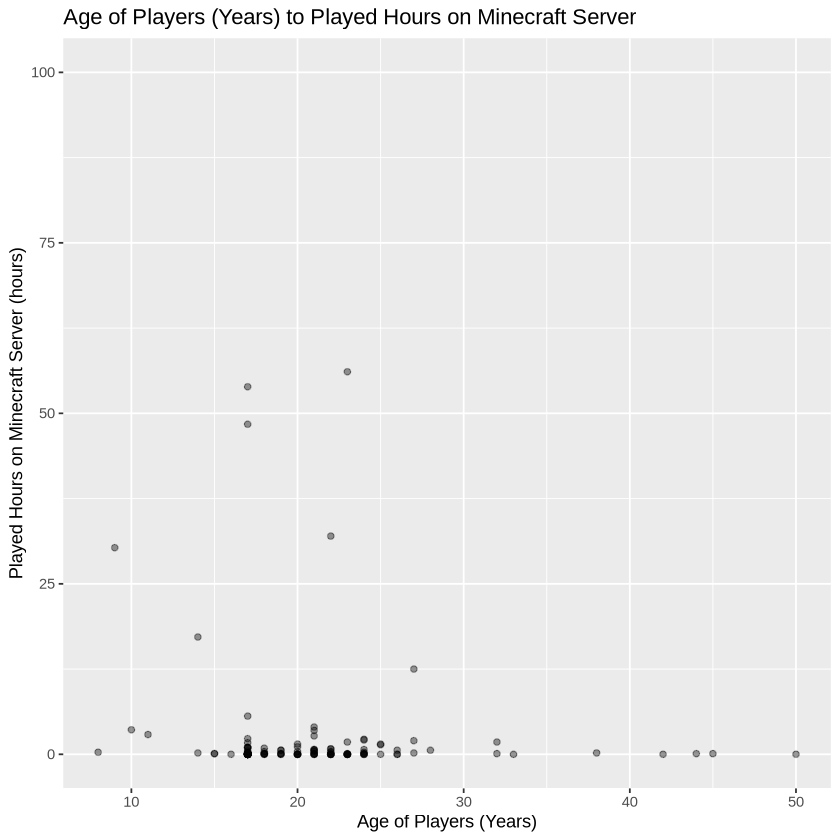

In [34]:
eda <- ggplot(players_train, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  xlab("Age of Players (Years)") +
  ylab("Played Hours on Minecraft Server (hours)") +
    ylim(0,100) +
    ggtitle("Age of Players (Years) to Played Hours on Minecraft Server")
eda


#### *Figure 1. Age of Players (Years) to Played Hours on Minecraft Server. Player ages are mostly between 15–25, with a few older outliers. Most play between 0–10 hours, with some outliers above 25 hours.*

***3. Setting up KNN regression***

First, we define a recipe to preprocess our data, which establishes the order of variables to predict using `Recipe()`. We set up the model to predict the number of played hours to the age of the player in the format `played_hours ~ age` to identify that `played_hours` is being predicted by `age`, from the training data set (`data = players_train`). `step_scale` and `step_center()` normalize the age predictor by standardize the age variable, essential for KNN as it prevents large values from dominating distance calculations asin the RMSPE. 

Next, we set up the model specification using `nearest_neighbor()` to define the prediction approach and how to take the distance of neighboring points. `weight_func = "rectangular"` ensures equal weighting for neighbors. `set_engine("kknn")` specifies the KNN engine, and `set_mode("regression")` directs the model to predict numerical values and use metrics like RMSPE for evaluation. This creates a clear and standardized model object to predict new data points based on the distance and labels of other data points.

Now, We use `vfold_cv(players_train, v = 5, strata = played_hours)` to create 5 subsets of the training data for cross-validation, which evaluates model performance on unseen data, and determine the accuracy of our classifier. The training data is split into folds, with the model trained on K-1 parts and tested on the remaining part. This process is repeated with 5 folds, and we assign it to `players_vfold`.

Finally, we combine everything into a workflow, linking our recipe and model specification together to define how the model predicts and interprets our data. `Workflow()` combines the preprocessed recipe and model of our `knn_spec` to a workflow, by using `add_recipe(players_recipe)` and `add_model(knn_spec)` to add the model, and assign the code as `players_workflow`. This workflow ensures that preprocessing and model fitting happen in a structured, repeatable way. We assign this to `players_workflow`. 

In [35]:
set.seed(5)

players_recipe <- recipe(played_hours ~ age, data = players_train) |> # This is according to the question
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec)

We tune the KNN regression model by testing K values from 1 to 50 (stepping by 2) using 5-fold cross-validation to determine which K is the best to use. Cross validation allows us to test the model with different K values and select the lowest prediction error on unseen data. This allows us to determine how the model behaves as K changes, and assess the accuracy of the model. First, we create a tibble of K values with `neighbors = seq(from = 1, to = min(50, nrow(players_train) - 1), by = 2)`, assigning it to `gridvals`. This grid helps the model assess the best K value to use, reducing ties in nearest neighbors. We then use `tune_grid()` to fit the model into a cross validation across 5 folds by using`resamples = players_vfold`, and `grid = gridvals`, which is used to train on one subset of the data and evaluate on the other. The `collect_metrics()` function gathers performance metrics, and `filter()` keeps only the RMSPE results, with the lowest RMSPE indicating the best K for the model's prediction accuracy.

In [36]:
set.seed(5)


gridvals <- tibble(neighbors = seq(from = 1, to = min(50, nrow(players_train) - 1), by = 2))

players_results <- players_workflow |>
 tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

head(players_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,23.66121,5,7.131193,Preprocessor1_Model01
3,rmse,standard,20.32177,5,7.246588,Preprocessor1_Model02
5,rmse,standard,20.60443,5,6.901952,Preprocessor1_Model03
7,rmse,standard,20.11366,5,7.027775,Preprocessor1_Model04
9,rmse,standard,19.62479,5,7.249493,Preprocessor1_Model05
11,rmse,standard,19.43575,5,7.306869,Preprocessor1_Model06


We identify the optimal number of neighbors by selecting the \( K \) value that corresponds to the lowest RMSPE, by fitlering `players_results`, to show only the minimum value of the root mean squared prediction error (RMSPE), or the squared difference between the predicted and true response value for each observation. The RSMPE in this data frame is the mean column. We use `filter(mean == min(mean))` to find the smallest RMSPE and therefore greatest accuracy. From this, we can determine K = 29 is the best neighbors value to use in our model.

In [37]:
set.seed(5)

players_min <- players_results |>
    filter(mean == min(mean))

players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,rmse,standard,18.96774,5,7.329566,Preprocessor1_Model15


We retrain the K-NN regression model using the entire training dataset with \( K = 29 \), based on the minimum K value `players_min`, labeled as `kmin`. We update the spec set with this value and label it `players_spec`. Then, we create a new workflow, `players_fit`, by adding `players_spec` as the model. Using this workflow, we predict the time played for each test observation with `predict(players_test)`, generating a `.pred` column, which contains the predicted numerical value for each observation. We then combine the predicted values with the actual test data using `bind_cols(players_test)` and compare the RMSPE of the actual played hours (`truth`) and the predictions (`.pred`) using `metrics(truth = played_hours, estimate = .pred)` to compare both measures.

In [38]:
set.seed(5)

kmin <- players_min |> pull(neighbors)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec) |>
  fit(data = players_train)

players_summary <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')
players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,40.37331


We create a `ggplot2` visualization to compare actual and predicted values based on played hours. The plot includes `geom_line` for the predicted values (.pred) with a line width of 1 to assess overfitting or underfitting. Axes are labeled, and the title dynamically reflects the selected number of neighbors in the KNN model (`"K = ", kmin`). The text size is adjusted for clarity using `theme(text = element_text(size = 12))`, and the plot is saved as `plot_final`. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


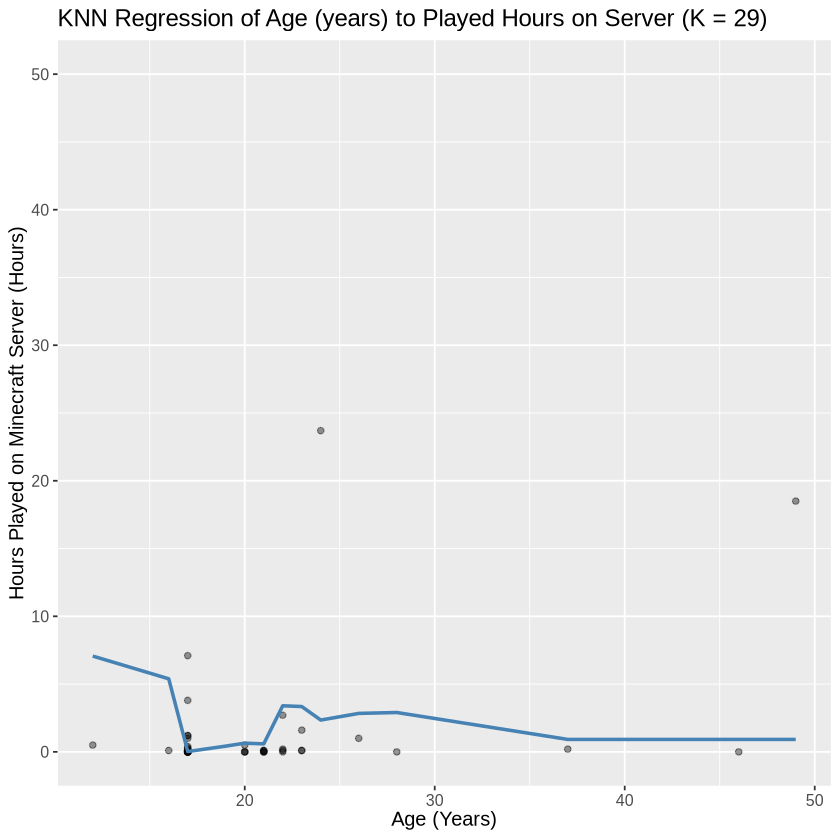

In [39]:
# Ensure the prediction grid includes 'age'
set.seed(5)

# Generate predictions
players_pred <- players_fit |>
  predict(players_test) |>
  bind_cols(players_test)

# Plot actual data points and prediction line
plot_final <- ggplot(players_test, aes(x = age, y = played_hours)) + 
  geom_point(alpha = 0.4) +
  geom_line(data = players_pred,
            mapping = aes(x = age, y = .pred),  # Ensure using correct column
            color = "steelblue",
            linewidth = 1) +
  xlab("Age (Years)") +
  ylab("Hours Played on Minecraft Server (Hours)") +
  theme(text = element_text(size = 12)) +
    ylim(0,50) +
    ggtitle("KNN Regression of Age (years) to Played Hours on Server (K = 29)")

plot_final


#### Figure 2. KNN Regression model of Age to Played Hours on the Minecraft Server, at K = 29. The KNN regression line shows a drop to near-zero hours for ages 10–20, a spike to ~4 hours between 20–25, and a plateau around 2 hours after age 30.

### ***Results***

The following graph above depicts the predicted trend of the KNN regression model. At approximately 10-20 years old, there is a sharp increase in the hours played. This coulde suggest younger players spend more hours playing. However, there is a significant decline as they become older. After the drop, the trend line stabilizes with only smaller fluctuations to suggest players in their 20s have more varied playtimes, but overall played hours remain between 0 to 10 hours. The model predicts almost no change in Hours Played for players aged 30 and above. This suggests that KNN does not detect strong variations in playtime for older individuals, possibly due to low sample density. Several extreme outliers are visible, especially above 20+ hours at ages around 20 and 50. These outliers may be affecting the model, pulling the regression line slightly upwards at certain points. There are many fluctuations in the early age range. The final model's RMSPE test error is 40.37 hours.

# **Discussion**

Analysis with KNN regression produced a model that overfit the data, likely because the K value chosen was too small, making it senitive to any noise/outliers in the data. With K = 29, the blue line representing the KNN regression predictions for hours played based on age is very jagged, especially between the ages 10 and 25, indicating A few outliers with very high play times may be skewing the model. After age 25, the model predicts nearly constant values for hours played, suggesting there are not enough data points taken past age 25 to accurately predict the played hours. The RMSPE of 40.37 is high relative as most data points are between 0 to 25 years old, indicating poor prediction accuracy and no clear relationship between age and hours played. The fitted data shows no clear trend. The results were partly expected as overfitting with small K values is a known behavior of KNN regression. However, a clearer trend was anticipated. The expected trend of older players spending less time playing was not clearly supported by the graph. These findings suggest KNN may not perform well on new data, especially for older age groups, and highlight the need for better age representation in future data collection. Finally, the sharp variations suggest the model is capturing more noise than meaningful trends, so other regression models would be worth exploring in future data analysis. Some future questions to explore could be the following, leading to more clear trends between time played to age:


1. **How does increasing `K` affect the smoothness of the regression line?**  
2. **Does adding more data for older individuals change the results?**  
3. **Are there other factors (e.g., gaming experience, preferred game genre) that better explain playtime than age?**  